In [1]:
import argparse
import math
from scipy.spatial import Delaunay
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon
from shapely.ops import polygonize_full, linemerge, unary_union
import geopandas as gpd
import pandas as pd

Define two auxiliary functions, one to get the Delaunay segments and one to polygonize the _head_ segments

In [2]:
def get_segments(points):
    coords = list(zip(points.geometry.x.values, points.geometry.y.values))
    TIN = Delaunay(coords)
    # list of coordinates for each edge
    edges = []
    for tr in TIN.simplices:
        for i in range(3):
            edge_idx0 = tr[i]
            edge_idx1 = tr[(i+1) % 3]
            edges.append(LineString((Point(TIN.points[edge_idx0]),
                                    Point(TIN.points[edge_idx1]))))

    edges = {'geometry':edges}
    edges_df = gpd.GeoDataFrame(edges)
    edges_df['length'] = edges_df.geometry.length
    return edges_df

def get_polygons(lines):
    linework = linemerge(lines.geometry.values)
    linework = unary_union(linework)
    result, _, _, _ = polygonize_full(linework)
    result = unary_union(result)
    result = {'geometry':result}
    result_df = gpd.GeoDataFrame(result)
    result_df.crs = {'init':'epsg:4326'}
    return result_df


First we get a dataframe with Delaunay edges and its lengths and plot the frequency distribution (also a vertical line wih the mean that separates head from tail)

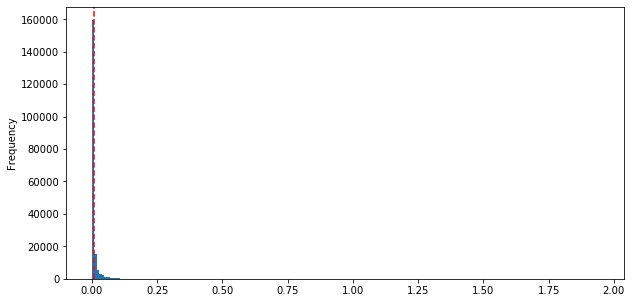

In [3]:
points_df = gpd.read_file("data/osm_nodes.shp")
#points_df = gpd.read_file("data/nodos_centro.dbf")
edges = get_segments(points_df)
edges.sort_values(by='length', inplace=True, ascending=False)
ax = edges['length'].plot(kind='hist', bins=200, figsize=(10,5))
ax.axvline(edges.mean(axis=0).length, color="red", linestyle="--")

With the mean we get the _head_ edges (those smaller than the mean) and polygonize them

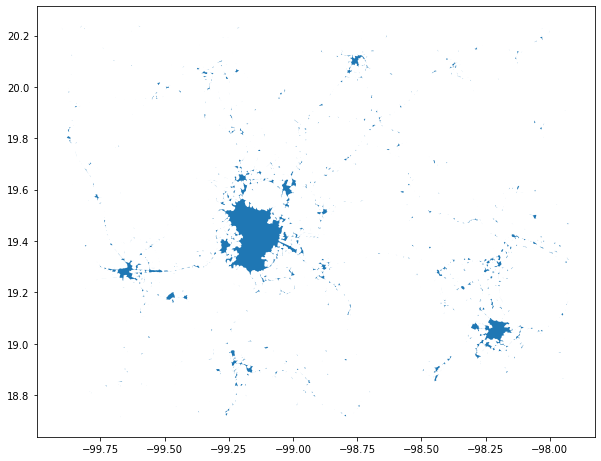

In [4]:
head = edges[edges['length'] < edges.mean(axis=0).length]
head_polygons = get_polygons(head)
head_polygons.plot(figsize=(10,10))

In [5]:
head_polygons.head()

,geometry
0,"POLYGON ((-99.671932 18.713654, -99.6719435 18..."
1,"POLYGON ((-98.7905071 18.715898, -98.7904867 1..."
2,"POLYGON ((-98.76314600000001 18.7293206, -98.7..."
3,"POLYGON ((-99.36644250000001 18.7374695, -99.3..."
4,"POLYGON ((-99.25766350000001 18.7211296, -99.2..."


For the next hierarchical level we need first to use only the points within the first level polygons, then for each of those polygons get the length distribution. For this, we need to refactor our polygon dataframe to include level and polygon ids

In [6]:
head_polygons['level'] = 'level_0'
head_polygons['poly_id'] = head_polygons.index
head_polygons.head()

,geometry,level,poly_id
0,"POLYGON ((-99.671932 18.713654, -99.6719435 18...",level_0,0
1,"POLYGON ((-98.7905071 18.715898, -98.7904867 1...",level_0,1
2,"POLYGON ((-98.76314600000001 18.7293206, -98.7...",level_0,2
3,"POLYGON ((-99.36644250000001 18.7374695, -99.3...",level_0,3
4,"POLYGON ((-99.25766350000001 18.7211296, -99.2...",level_0,4


Now, lets work with the largest level 0 polygon 

In [10]:
head_polygons.area.sort_values(ascending=False)

1070    3.779570e-02
233     5.735529e-03
518     2.714099e-03
1051    1.706115e-03
1069    1.382747e-03
            ...     
112     6.477100e-10
954     6.457000e-10
158     5.444100e-10
846     3.421200e-10
241     4.473500e-11
Length: 1090, dtype: float64

In [16]:
poly = head_polygons.iloc[[1070]]
poly

,geometry,level,poly_id
1070,"POLYGON ((-99.10876519999999 19.2919085, -99.1...",level_0,1070


Lets get all the points _within_ that polygon

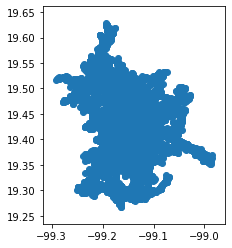

In [17]:
points = gpd.sjoin(points_df, poly)
points.plot()

In [18]:
points.head()

,id,cnt,chk,ein,eout,geometry,index_right,level,poly_id
4458,4459.0,None,None,None,None,POINT (-99.21992539999999 19.3122636),1070,level_0,1070
4461,4462.0,None,None,None,None,POINT (-99.2399131 19.3028121),1070,level_0,1070
4496,4497.0,None,None,None,None,POINT (-99.2487838 19.3059028),1070,level_0,1070
4498,4499.0,None,None,None,None,POINT (-99.2400215 19.2941178),1070,level_0,1070
4499,4500.0,None,None,None,None,POINT (-99.2401541 19.2943963),1070,level_0,1070


Now we can calculate the length distribution for the Delaunay edges for this points

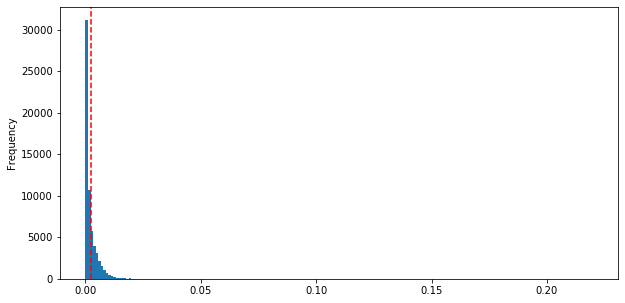

In [19]:
edges = get_segments(points)
edges.sort_values(by='length', inplace=True, ascending=False)
ax = edges['length'].plot(kind='hist', bins=200, figsize=(10,5))
ax.axvline(edges.mean(axis=0).length, color="red", linestyle="--")

Again, we select those smaller than the mean and polygonize them

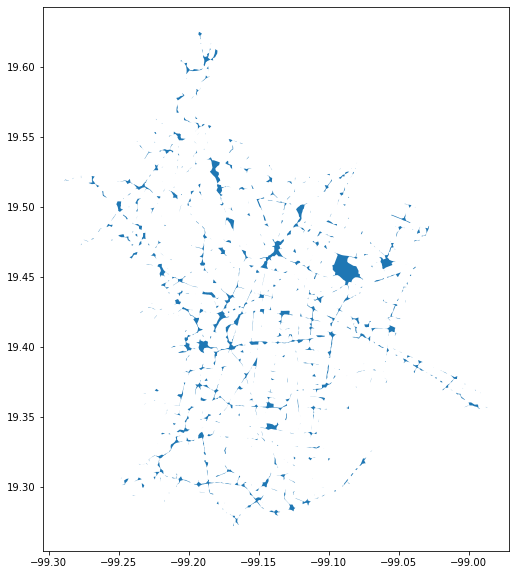

In [20]:
head = edges[edges['length'] < edges.mean(axis=0).length]
head_polygons = get_polygons(head)
head_polygons.plot(figsize=(10,10))

Now lets get the size distributions _for each_ polygon in the first level

In [8]:
points_1 = gpd.sjoin(points_df, head_polygons)
level = []
for poly in points_1['poly_id'].unique():
    p = points_1[points_1['poly_id'] == poly]
    if p.shape[0] > 500: ## we dont want polygons with very few points, although this is quite arbitrary
        l = get_segments(p)['length'].rename(poly)
        level.append(l)
lengths_1 = pd.concat(level, axis=1)
lengths_1.head()

,1779,8929,1473,7881,8690,5163,3439,8691,2151,8296,...,937,2659,3080,3816,7861,9000,3304,1402,104,3398
0,0.001244,0.003114,0.044947,0.011757,0.000770,0.001000,0.018410,0.007262,0.100034,0.011732,...,0.000600,0.007494,0.003735,0.000540,0.004854,0.004577,0.048385,0.001279,0.007010,0.002771
1,0.004661,0.014018,0.017702,0.016177,0.000896,0.010103,0.017902,0.001930,0.067423,0.020264,...,0.006628,0.003503,0.006892,0.000915,0.005665,0.005282,0.052625,0.001395,0.017583,0.003483
2,0.005902,0.011370,0.028054,0.004484,0.001611,0.009164,0.000515,0.009189,0.037338,0.008600,...,0.006030,0.010992,0.009938,0.000376,0.010330,0.000792,0.004417,0.000874,0.010593,0.000713
3,0.000481,0.000364,0.018025,0.001943,0.002198,0.001693,0.050372,0.000507,0.048088,0.002665,...,0.004852,0.001622,0.004415,0.001736,0.013392,0.002231,0.003455,0.004966,0.000394,0.002771
4,0.000828,0.011370,0.020252,0.000577,0.002557,0.003994,0.007416,0.001773,0.015592,0.008600,...,0.006030,0.001515,0.000316,0.006093,0.015759,0.002917,0.004417,0.004889,0.001033,0.000804


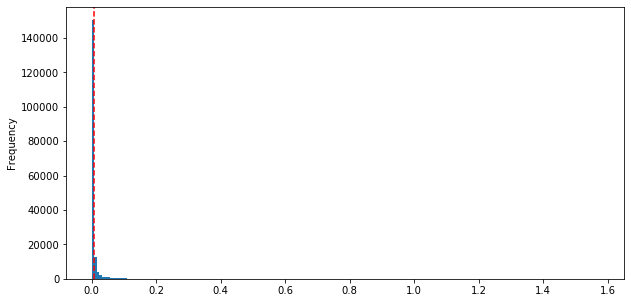

In [36]:
points_1 = gpd.sjoin(points_df, head_polygons)
edges_1 = get_segments(points_1)
edges_1.sort_values(by='length', inplace=True, ascending=False)
ax = edges_1['length'].plot(kind='hist', bins=200, figsize=(10,5))
ax.axvline(edges_1.mean(axis=0).length, color="red", linestyle="--")

Now we separate the _head_ and polygonize it.

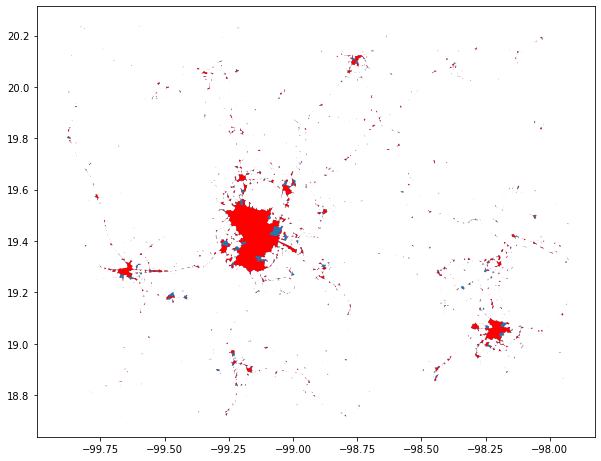

In [43]:
head_1 = edges_1[edges_1['length'] < edges_1.mean(axis=0).length]
head_polygons_1 = get_polygons(head_1)
ax = head_polygons.plot(figsize=(10,10))
head_polygons_1.plot(figsize=(10,10), ax=ax, color='red')

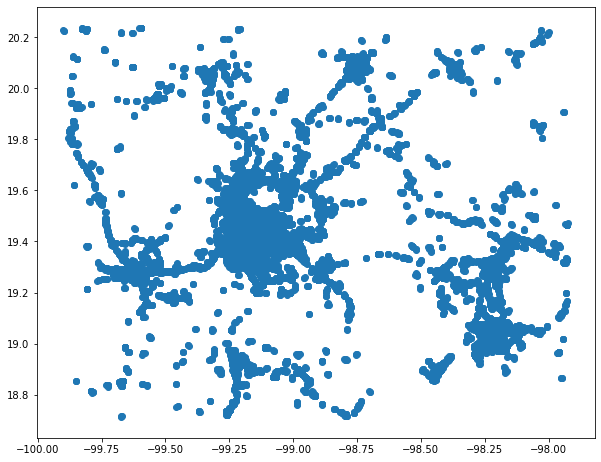

In [38]:
points_1.plot(figsize=(10,10))

In [10]:
points_df = gpd.read_file("data/osm_nodes.shp")

coords = list(zip(points_df.geometry.x.values, points_df.geometry.y.values))
TIN = Delaunay(coords)
# list of coordinates for each edge
edges = []
for tr in TIN.simplices:
    for i in range(3):
        edge_idx0 = tr[i]
        edge_idx1 = tr[(i+1) % 3]
        edges.append(LineString((Point(TIN.points[edge_idx0]),
                                Point(TIN.points[edge_idx1]))))

edges = {'geometry':edges}
edges_df = gpd.GeoDataFrame(edges)
edges_df['length'] = edges_df.geometry.length
edges_df.head()
#edges_df.sort_values(by='length', inplace=True, ascending=False)
#edges_df['length'].plot(kind='barh')

,geometry,length
0,"LINESTRING (-97.76540660000001 20.3810637, -97...",0.771271
1,"LINESTRING (-97.7635854 19.6097945, -97.472947...",1.107417
2,"LINESTRING (-97.4729478 18.5411961, -97.765406...",1.862967
3,"LINESTRING (-98.95869039999999 20.3524357, -97...",1.193627
4,"LINESTRING (-97.76540660000001 20.3810637, -99...",1.943399


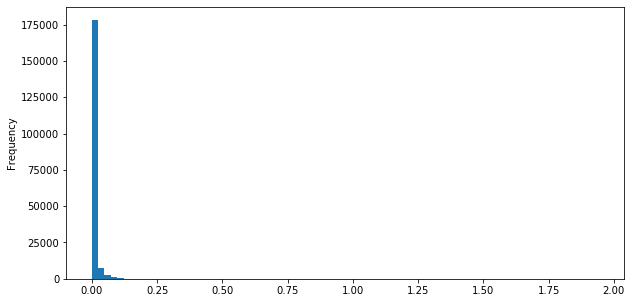

In [26]:
edges_df['length'].plot(kind='hist', bins=80, figsize=(10,5))

In [27]:
head = edges_df[edges_df['length'] < edges_df.mean(axis=0).length]
linework = linemerge(head.geometry.values)
linework = unary_union(linework)
result, _, _, _ = polygonize_full(linework)
result = unary_union(result)
result = {'geometry':result}
result_df = gpd.GeoDataFrame(result)
result_df.crs = {'init':'epsg:4326'}

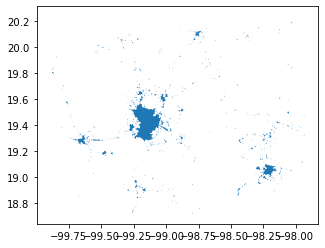

In [28]:
result_df.plot()

In [ ]:
points_1 = gpd.sjoin(points_df, result_df)
